# Ultra-High-Density Recording Baseline Subtractor

- Subtracts filtered probe trace from a an experiment trace
- Not practical for a whole recording but might help with representative traces for presentations

## User Input

In [1]:
# Assumes this python notebook, the data file, and the imp. file are in same dir
datafile = 'experiment_C20200403-105044_filtered_64.h5'
basefile = 'experiment_C20200403-111923_probe_64.h5' # Saline baseline file
fs = 30000
chan_range = [0,63] # starting at channel 0, not channel 1
start_time = 0
col_num = 3 # columns per shank
row_num = [21,20,21] # rows per column (# values should == # columns)

## Import Dependencies

In [2]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.signal import butter, sosfiltfilt, sosfreqz
import time

## Read in the Multichannel Data

In [3]:
window = [start_time * fs, start_time + 1 *fs]
channels = list(range(chan_range[0], chan_range[1]))
f_data = h5py.File(datafile, 'r')
f_base = h5py.File(basefile, 'r')

xs = f_data.get('x') # channel # (x)
ys = f_data.get('y') # actual data in microvolts (y)
ys = ys[:, channels]

subs_y = f_base.get('filtered_y') # Get baseline y for all channels
subs_y = subs_y[:, channels]
filtered_stats = f_base.get('filtered_stats') # 0-means, 1-medians, 2-std, 3-ranges

## Subtract Unfiltered baseline data from signals

In [4]:
import pandas as pd

df = pd.DataFrame()
for channel in channels:
    clean_y = []
    for x in list(range (window[0], window[1])): 
        temp = float(ys[x,channel]) - float(subs_y[x,channel]) # cast as float to avoid ushort_scalar error
        clean_y.append(temp)
    df[channel] = clean_y
    
df['x'] = [i for i in range(0, int(len(df[0])))]

## Save Subtracted Data

In [5]:
hf_sub = h5py.File(datafile.replace('.h5', '_subtracted.h5'), 'w')
hf_sub.create_dataset('x', data = df['x'])
hf_sub.create_dataset('subtracted', data=df.loc[:, df.columns != 'x'])
hf_sub.close()

## Plot subtracted data as grid

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 

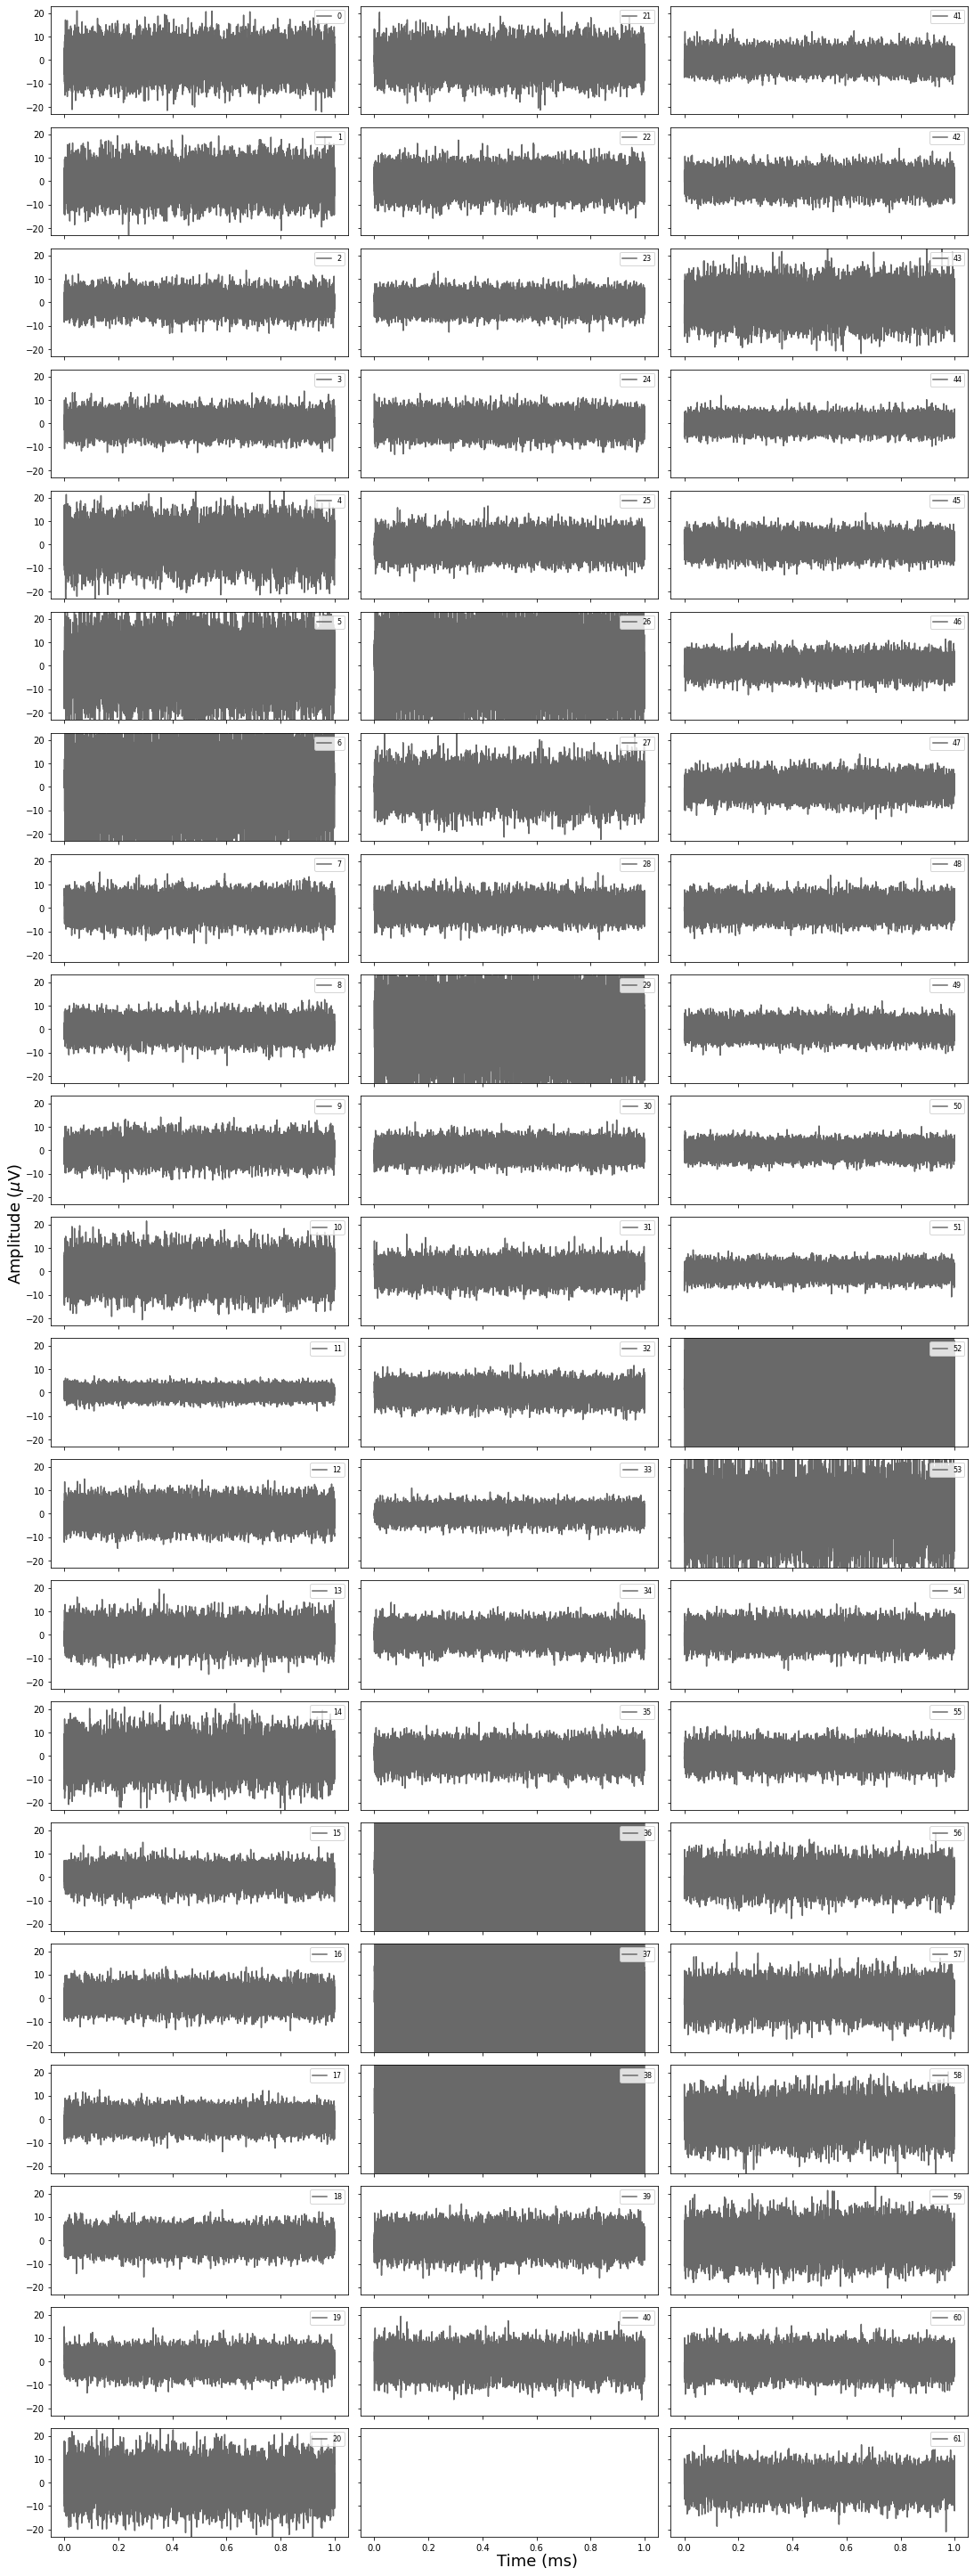

In [7]:
def grid_plot_subtracted(chans, start, end):
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (21,3, figsize =(15,40), sharex = True, sharey = True)
    j = 0
    ch_num = 0
    for j in range (0,col_num):
        i = 0
        for i in range (0,row_num[j]): 
            print(ch_num, end = ' ')
            ax[i][j].plot(xs[start:end]/fs, df.iloc[start:end,ch_num], color = 'dimgray', 
                            label=str(ch_num)) # Filtered Signal
            handles, labels = ax[i][j].get_legend_handles_labels()
            ax[i][j].legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
            ax[i][j].set_ylim(filtered_stats[ch_num, 0] - filtered_stats[ch_num, 3]*0.75, 
                              filtered_stats[ch_num, 0] + filtered_stats[ch_num, 3]*0.75)
            plt.tight_layout()
            ch_num = ch_num + 1
    fig.text(0.0, 0.5, r'Amplitude ($\mu$V)', ha='center', rotation='vertical', fontsize = 18)
    fig.text(0.5, 0.0, 'Time (ms)', va='center',  fontsize = 18)
    plt.savefig (basefile.replace('.h5','_grid_subtracted_' + str(chan_range[1]) + '.png'))
    display(HTML('<hr>'))

shank_num = 1
win = [0,30000] 
chans = list(np.arange(0,shank_num*(col_num + sum(row_num))))
grid_plot_subtracted(chans, win[0], win[1])